In [2]:
import os
import shutil
import pandas as pd
import numpy as np
from datetime import datetime
from pathlib import Path
from contextlib import redirect_stdout
import itertools
from PIL import Image
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [4]:
path_df = 'ISIC2018_Task3_Training_GroundTruth/'
df=pd.read_csv(os.path.join(os.getcwd(), path_df, 'ISIC2018_Task3_Training_GroundTruth.csv'))

random_images_names = ['ISIC_0024318', 'ISIC_0027650', 'ISIC_0027517', 'ISIC_0028369']
df[df.image.isin(random_images_names)]

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC
12,ISIC_0024318,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3211,ISIC_0027517,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3344,ISIC_0027650,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4063,ISIC_0028369,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [5]:
df.loc[df['MEL'] == 1, 'MEL'] = 'MEL'
df.loc[df['NV'] == 1, 'NV'] = 'NV'
df.loc[df['BCC'] == 1, 'BCC'] = 'BCC'
df.loc[df['AKIEC'] == 1, 'AKIEC'] = 'AKIEC'
df.loc[df['BKL'] == 1, 'BKL'] = 'BKL'
df.loc[df['DF'] == 1, 'DF'] = 'DF'
df.loc[df['VASC'] == 1, 'VASC'] = 'VASC'

classes = df.set_index('image').values.tolist()
filenames = df.image.tolist()

img_label_df = pd.DataFrame({'filename':filenames, 'label':classes}).sample(frac=1).reset_index(drop=True)
img_label_df['label'] = img_label_df['label'].apply(lambda row: [val for val in row if val != 0][0])
img_label_df[img_label_df.filename.isin(random_images_names)]

,filename,label
594,ISIC_0024318,DF
6678,ISIC_0027650,AKIEC
9039,ISIC_0028369,NV
9351,ISIC_0027517,MEL


In [6]:
def append_ext(fn):
    return fn+".jpg"

img_label_df['filename']=img_label_df['filename'].apply(append_ext)

img_label_df.to_csv('GroundTruth_df.csv', columns=['filename', 'label'], index=False)
img_label_df.head()

,filename,label
0,ISIC_0032148.jpg,NV
1,ISIC_0032497.jpg,BCC
2,ISIC_0034262.jpg,MEL
3,ISIC_0033656.jpg,NV
4,ISIC_0028067.jpg,NV


In [21]:
img_label_df.label.value_counts()

NV       6705
MEL      1113
BKL      1099
BCC       514
AKIEC     327
VASC      142
DF        115
Name: label, dtype: int64

In [22]:
labels_list = img_label_df.label.unique()

NV_df = img_label_df[img_label_df.label == 'NV']
NV_df_random = NV_df.sample(frac=1/6)
len(NV_df_random)

img_label_df = img_label_df[img_label_df.label != 'NV']
img_label_df = img_label_df.append(NV_df_random)
img_label_df.label.value_counts()

img_label_df = img_label_df[img_label_df.label.isin(['NV', 'MEL', 'BKL'])]
img_label_df.label.value_counts()

1118

NV       1118
MEL      1113
BKL      1099
BCC       514
AKIEC     327
VASC      142
DF        115
Name: label, dtype: int64

NV     1118
MEL    1113
BKL    1099
Name: label, dtype: int64

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(img_label_df.filename, img_label_df.label, 
                                                    test_size=0.30, random_state=42, stratify=img_label_df.label)

X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, 
                                                    test_size=0.50, random_state=42, stratify=y_temp)

folders_list = ['train', 'valid', 'test']
data_subsets_filename_list = [X_train, X_valid, X_test] #filename (np.00001.jpg)
data_subsets_label_list = [y_train, y_valid, y_test] #label (np. NV)

data_path = os.path.join(os.getcwd(),'ISIC2018_Task3_Training_Input/')

for i, folder in enumerate(folders_list):
    cd_subdatasets = os.path.join(os.getcwd(), folder)
    os.mkdir(cd_subdatasets) if not os.path.isdir(cd_subdatasets) else None
    for class_name in labels_list:
        cd = os.path.join(os.getcwd(), folder, class_name)
        os.mkdir(cd) if not os.path.isdir(cd) else None
        print('Utworzono folder: ', folder+'/'+class_name) 
   
        for filename, label in zip(data_subsets_filename_list[i], data_subsets_label_list[i]):   
            if label == class_name:
                shutil.copy(data_path+filename, cd) 
       
    print('Zapisano zdjęcia w folderze', folder+'/'+class_name)

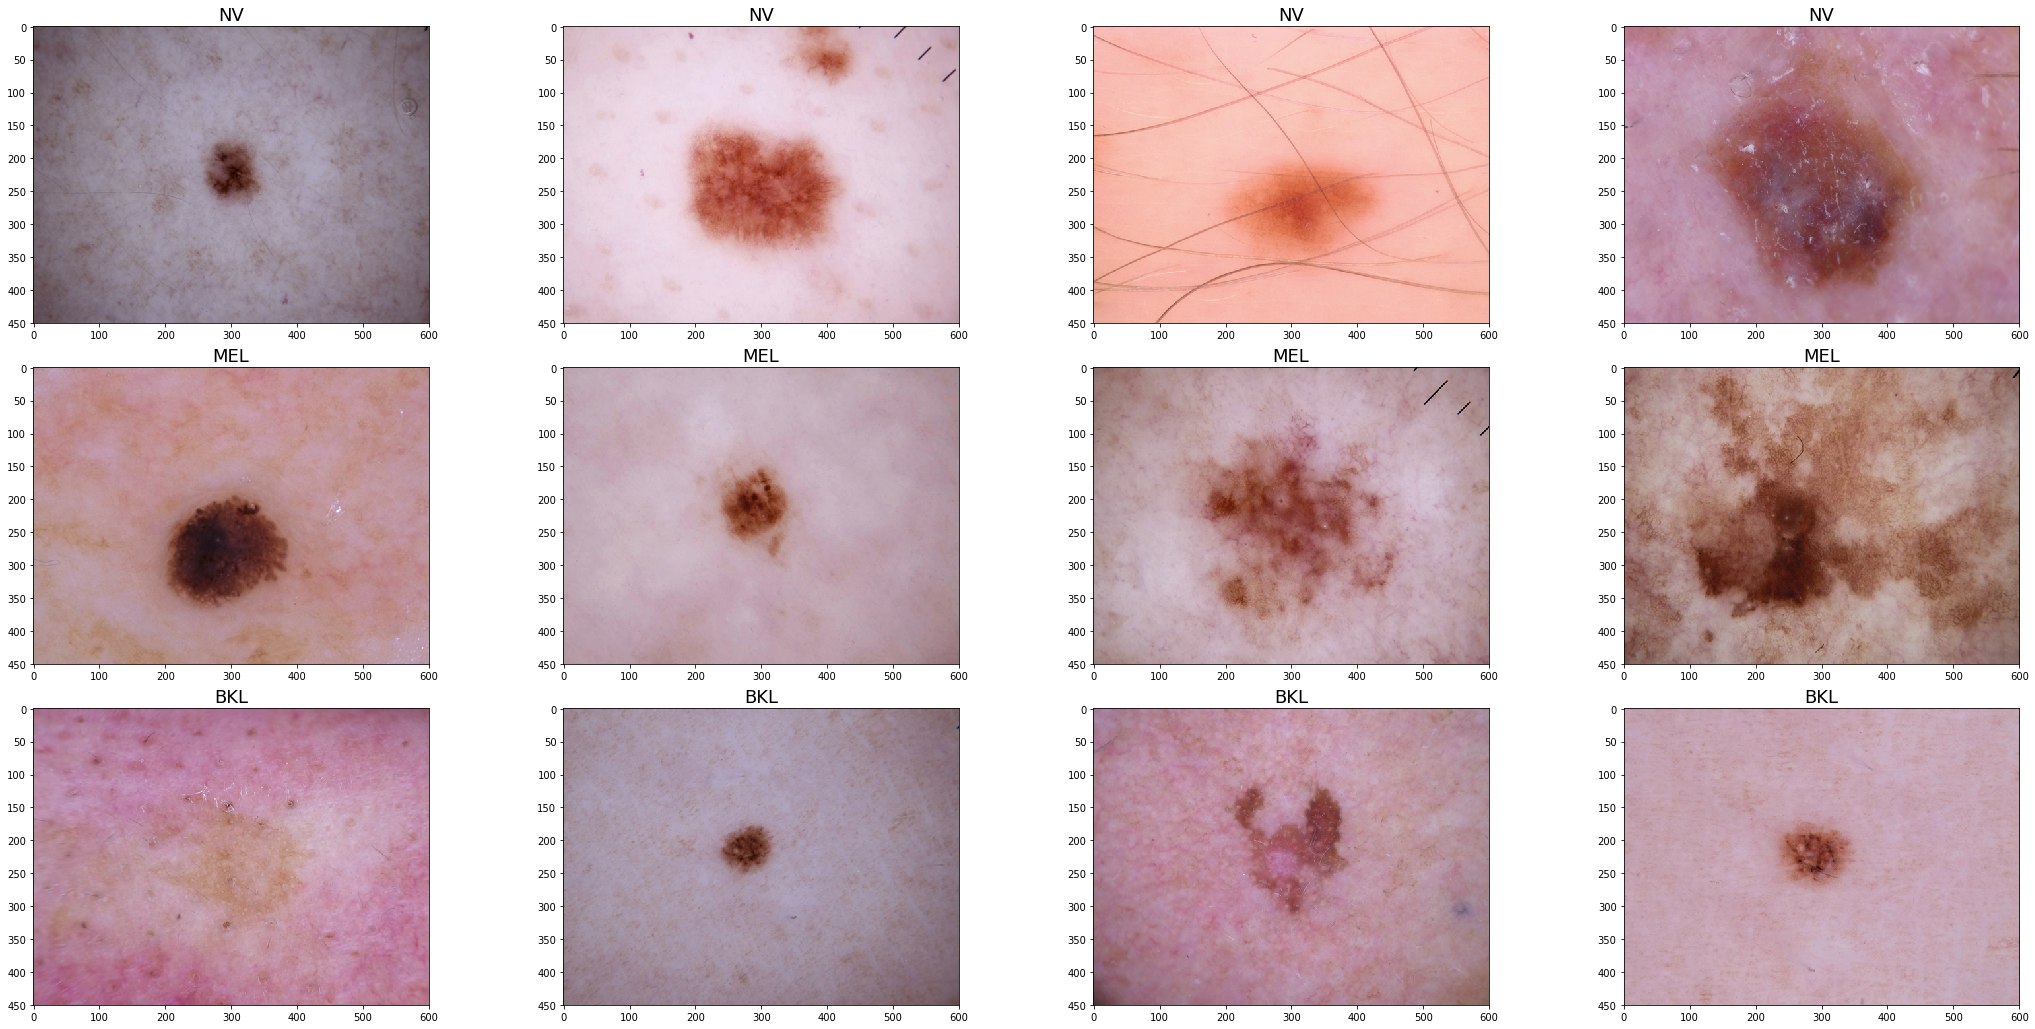

In [64]:
class_list = ['NV', 'MEL', 'BKL']

fig, axs = plt.subplots(3,4, figsize=(38,18))
fig.subplots_adjust(hspace = .15, wspace=.0001)
axs = axs.ravel()

num_of_axes = 0
for index, c in enumerate(class_list):
    selected = os.listdir('train/'+c+'/')

    for x in range(4):
        image = Image.open('train/'+c+'/'+selected[x+55])
        title = c
        
        axs[num_of_axes].imshow(image)
        axs[num_of_axes].set_title(title, {'fontsize': 18})
        num_of_axes += 1

plt.show();

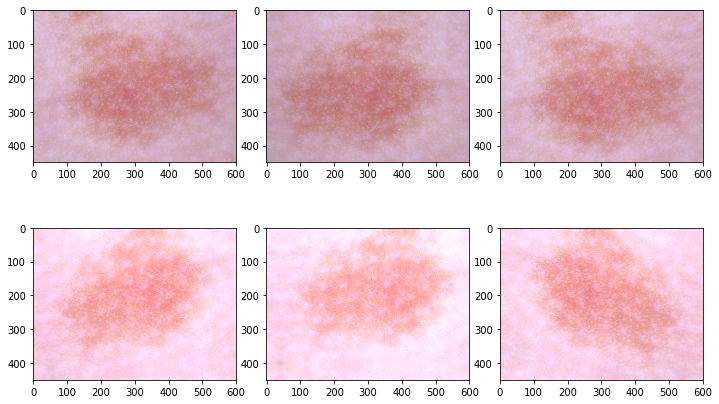

In [22]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from numpy import expand_dims
from matplotlib import pyplot
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from tensorflow.keras.applications.xception import preprocess_input as preprocess_input_Xception
# augment_param = {'brightness_range':[0.2,2.2]} 
# augment_param = {'zoom_range':[0.2,2.2]} 
# augment_param = {'zoom_range':[0.2,0.8]}
# augment_param = {'rotation_range':135}
# augment_param = {'horizontal_flip':True}
# augment_param = {'vertical_flip':True} 
# augment_param = {'width_shift_range':0.5} 
# augment_param = {'height_shift_range':0.5} 
# augment_param = {'zca_whitening':True}
# augment_param = {'preprocessing_function':get_random_eraser(p=0.8, v_l=0, v_h=0.4, pixel_level=False)}
# https://arxiv.org/pdf/1708.04896.pdf

# elastic_transform(kot, alpha = kot.shape[1] * 3, sigma = kot.shape[1] * 0.07)

augment_param = {'brightness_range':[0.75,1.25],
                'horizontal_flip': True,
                 'vertical_flip':True,
                'width_shift_range':50,
                'height_shift_range':50,
                 'rotation_range':30,
                'fill_mode': 'reflect',
                 'zca_whitening':True,
#                 'rescale':1./255,
#                 'preprocessing_function':preprocess_input_Xception,
                }

path = os.path.join("C:\\", "Users", "jazzu", "ISIC_2018", "data", "train", "BKL", 'ISIC_0029427.jpg')
img = load_img(path)
data = img_to_array(img)
samples = expand_dims(data, 0)

datagen = ImageDataGenerator(**augment_param)
it = datagen.flow(samples, batch_size=1)

pyplot.figure(figsize=(12,8))
for i in range(6):
    pyplot.subplot(230 + 1 + i)
    pyplot.subplots_adjust(hspace = .002, wspace=0.15)
    batch = it.next()
    image = batch[0].astype('uint8')
    pyplot.imshow(image)

pyplot.show();

In [21]:
df['Predictions'].value_counts()

MEL    187
BKL    171
NV     142
Name: Predictions, dtype: int64

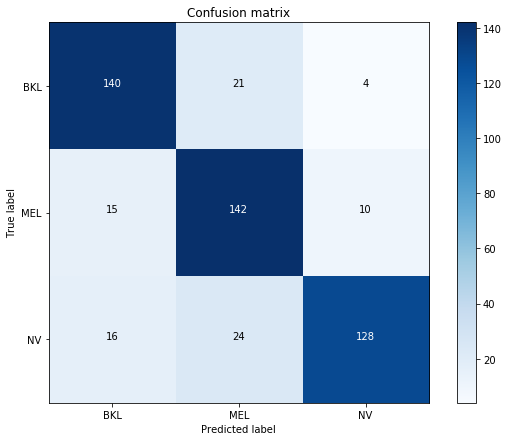

In [26]:
df = pd.read_csv('20190921-202422_Xceptionisic.csv')
df['True'] = df['Filename'].str[:2]
df['Predictions'] = df['Predictions'].str[:2]
df = df[['True', 'Predictions']]

from sklearn.metrics import confusion_matrix
cm=confusion_matrix(df['True'], df['Predictions'])
cmap=plt.cm.Blues

classes = ['BKL', 'MEL', 'NV']

plt.figure(figsize=(10,7))
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

# plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.savefig('isic_cm.png');
plt.savefig('isic_cm.jpg');